In [167]:
#Se importan librerías iniciales
!pip install rlxutils
import os
import pandas as pd
import numpy as np
from rlxutils import subplots
import matplotlib.pyplot as plt

#Se importan otras librerías requeridas
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


#Se cargan los datos de Kagle
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

#Se extraen y descomprimen archivos
!unzip udea*.zip > /dev/null

#Se carga el archivo "train.csv"
GetFileTrain = pd.read_csv("train.csv")

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [168]:
#Se imprimen los primeros datos del Dataset
display(GetFileTrain.head())

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


In [169]:
#Información general de las columnas del Dataset
print(GetFileTrain.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   ID                              692500 non-null  int64 
 1   PERIODO                         692500 non-null  int64 
 2   ESTU_PRGM_ACADEMICO             692500 non-null  object
 3   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object
 4   ESTU_VALORMATRICULAUNIVERSIDAD  686213 non-null  object
 5   ESTU_HORASSEMANATRABAJA         661643 non-null  object
 6   FAMI_ESTRATOVIVIENDA            660363 non-null  object
 7   FAMI_TIENEINTERNET              665871 non-null  object
 8   FAMI_EDUCACIONPADRE             669322 non-null  object
 9   FAMI_EDUCACIONMADRE             668836 non-null  object
 10  ESTU_PAGOMATRICULAPROPIO        686002 non-null  object
 11  RENDIMIENTO_GLOBAL              692500 non-null  object
dtypes: int64(2), object(10)
memory

# **Exploración Global de Datos**.

A continuación se pretende realizar un análisis sobre cada una de las columnas del Dataset.
Se pretende crear una función que permita evaluar cada columna según el tipo de contenido, obtener datos relevantes y graficar respecto a los valores de rendimiento.

In [170]:
#Se excluye la columna "ID" en el análisis
Data = GetFileTrain.drop(columns=['ID'])


#Se define función para analizar cada una de las columnas
def InfoColumns(data):
    for column in data.columns:
        print(f"\nAnálisis de la columna: {column}")

        #Se muestra la cantidad de valores únicos para cada columna
        print(f"Valores únicos: {data[column].nunique()}")

        #Se muestran los valores más comunes
        print(f"Valores más comunes:\n{data[column].value_counts().head()}")

        #Validar si existen valores nulos
        missing = data[column].isnull().sum()
        print(f"Valores nulos en {column}: {missing}")

        print("------------------------------------------------------------------")


#Llamar a la función para analizar las columnas del dataset
InfoColumns(Data)


Análisis de la columna: PERIODO
Valores únicos: 9
Valores más comunes:
PERIODO
20195    180873
20203    171838
20212    171412
20183    164818
20194      1472
Name: count, dtype: int64
Valores nulos en PERIODO: 0
------------------------------------------------------------------

Análisis de la columna: ESTU_PRGM_ACADEMICO
Valores únicos: 948
Valores más comunes:
ESTU_PRGM_ACADEMICO
DERECHO                       53244
ADMINISTRACION DE EMPRESAS    51902
CONTADURIA PUBLICA            39664
PSICOLOGIA                    31932
INGENIERIA INDUSTRIAL         28481
Name: count, dtype: int64
Valores nulos en ESTU_PRGM_ACADEMICO: 0
------------------------------------------------------------------

Análisis de la columna: ESTU_PRGM_DEPARTAMENTO
Valores únicos: 31
Valores más comunes:
ESTU_PRGM_DEPARTAMENTO
BOGOTÁ       282159
ANTIOQUIA     83607
VALLE         44588
ATLANTICO     41020
SANTANDER     28828
Name: count, dtype: int64
Valores nulos en ESTU_PRGM_DEPARTAMENTO: 0
--------------------

Con base en la información obtenida se realiza limpieza y ajuste de los diferentes datos

# **Columna PERIODO**
- Los valores de periodo se tratarán por años. Es decir: 20191, 20192, ... será tratado simplemente como 2019.
- No existen Valores Nulos

Valores únicos en la columna PERIODO:
[2021 2020 2019 2018]


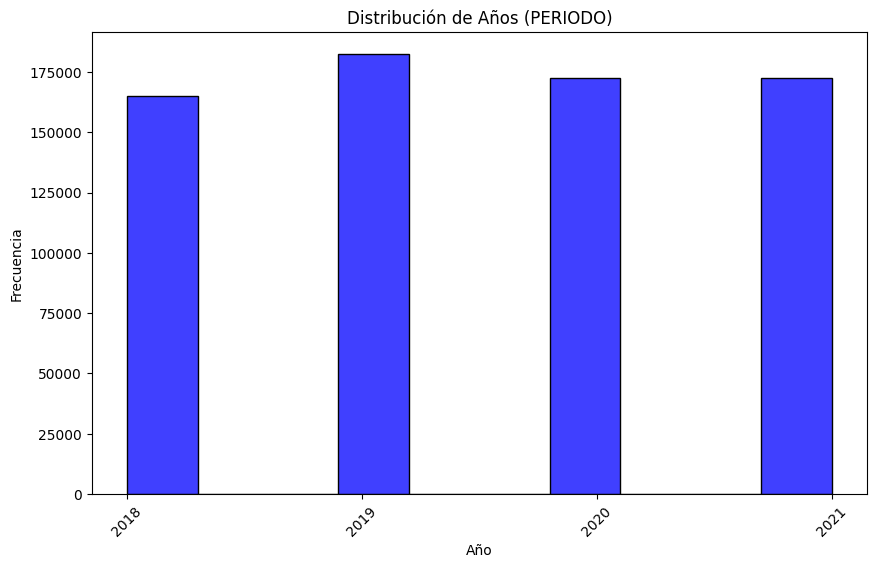

<ipython-input-172-86f9351269cd>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_year, ax=ax, palette="viridis")
<ipython-input-172-86f9351269cd>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_year, ax=ax, palette="viridis")
<ipython-input-172-86f9351269cd>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_year, ax=ax, palette="viridis")
<ipython-input-172-86f9351269cd>:30: FutureWarning: 

Passing `palette` without assigning `hue

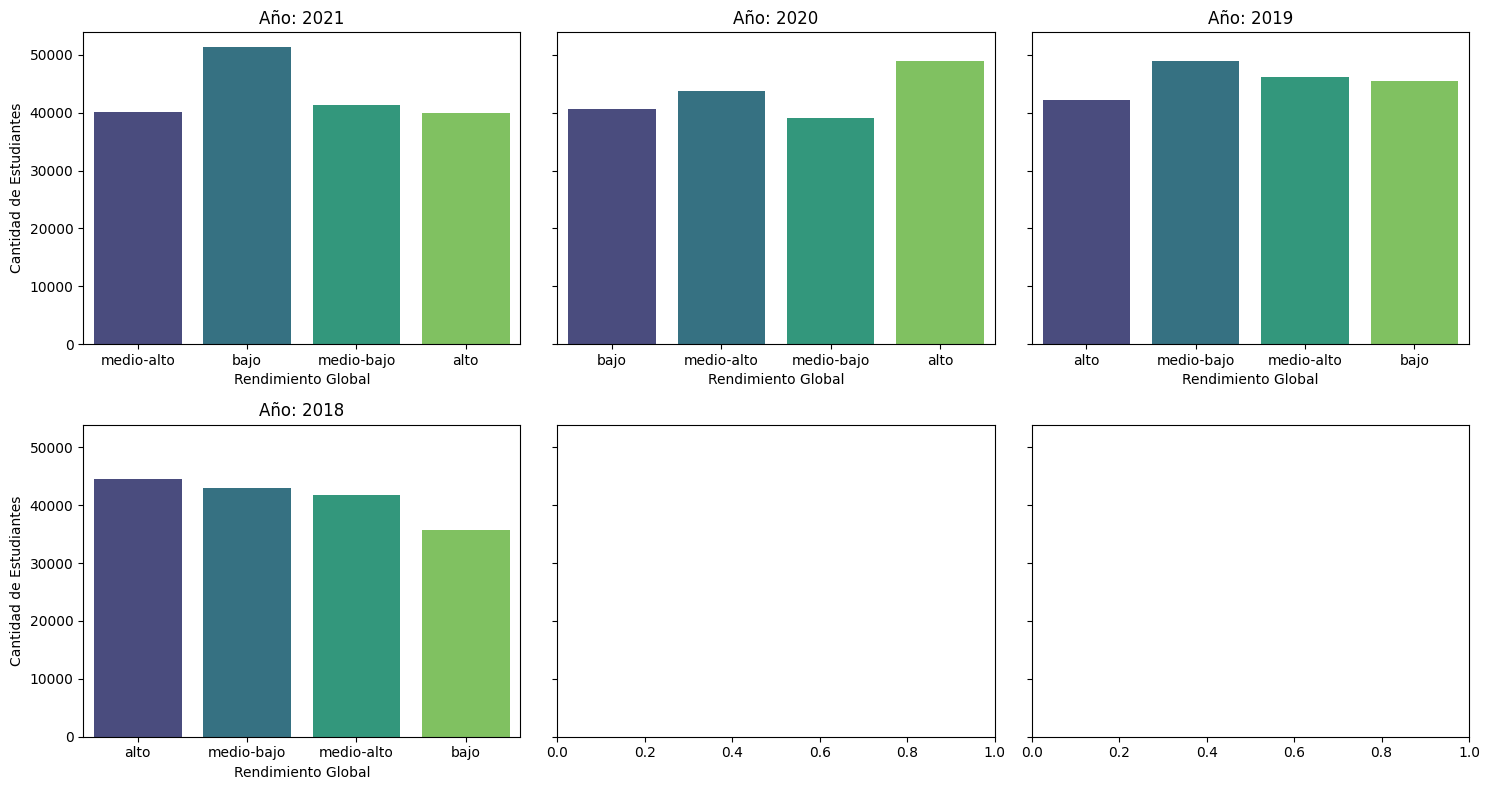

In [172]:
#Modificar la columna 'PERIODO' para que solo contenga el año
Data['PERIODO'] = Data['PERIODO'].astype(str).str[:4].astype(int)

#Verificar los cambios en la columna PERIODO
valores_unicos = Data['PERIODO'].unique()
print("Valores únicos en la columna PERIODO:")
print(valores_unicos)

#Histograma de los años en la columna PERIODO
plt.figure(figsize=(10, 6))
sns.histplot(Data['PERIODO'], kde=False, bins=10, color='blue')
plt.xticks(Data['PERIODO'].unique(), rotation=45)
plt.title('Distribución de Años (PERIODO)')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()


#Graficar los rendimientos por año en un gráfico de dispersión
unique_years = Data['PERIODO'].unique()
#Crear una figura con subplots, uno por cada año
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)
axes = axes.flatten()
#Iterar sobre cada año para crear un gráfico de barras por cada uno
for i, year in enumerate(unique_years):
    ax = axes[i]
    #Filtrar los datos para el año correspondiente
    data_year = Data[Data['PERIODO'] == year]
    #Crear gráfico de barras para el año
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_year, ax=ax, palette="viridis")
    #Título para cada subplot
    ax.set_title(f'Año: {year}')
    # Etiquetas
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

# Ajustar el layout
plt.tight_layout()
plt.show()

# **Columna ESTU_PRGM_ACADEMICO**

En este caso se tiene un archivo Excel que se obuvo del portal del Ministerio de Educación:

https://hecaa.mineducacion.gov.co/consultaspublicas/programas

Se obtivieron datos de los diferentes programas académicos ofrecidos en Colombia y se organizaron según categoría especifica (Filtro en el portal)

La idea es cargar el archivo Excel "Programas.xlsx", convertir los datos a mayúsculas en el Dataset y reemplazarlos en el dataset según coincidencias con el archivo Excel

In [173]:
import unicodedata

#Función para eliminar tildes y normalizar el texto
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.upper()
        texto = ''.join((c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'))
    return texto

#Cargar el archivo Excel "Programas.xlsx" y seleccionar la hoja "Sheet1"
programas_df = pd.read_excel('Programas.xlsx', sheet_name='Sheet1')

#Asegurarse de que los datos en la columna "ESTU_PRGM_ACADEMICO" estén normalizados
Data['ESTU_PRGM_ACADEMICO'] = Data['ESTU_PRGM_ACADEMICO'].apply(normalizar_texto)

#Normalizar también la columna 'Programa' y 'Campo de Conocimiento' en el archivo Excel
programas_df['Programa'] = programas_df['Programa'].apply(normalizar_texto)
programas_df['Campo de Conocimiento'] = programas_df['Campo de Conocimiento'].apply(normalizar_texto)

#Crear un diccionario para coincidencias exactas entre 'Programa' y 'Campo de Conocimiento'
reemplazos = dict(zip(programas_df['Programa'], programas_df['Campo de Conocimiento']))

#Reemplazar las coincidencias exactas en la columna 'ESTU_PRGM_ACADEMICO'
Data['ESTU_PRGM_ACADEMICO'] = Data['ESTU_PRGM_ACADEMICO'].replace(reemplazos)

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_PRGM_ACADEMICO'].head())

0                           SALUD
1    CCIAS SOCIALES Y HUMANIDADES
2                CCIAS ECONOMICAS
3                CCIAS ECONOMICAS
4    CCIAS SOCIALES Y HUMANIDADES
Name: ESTU_PRGM_ACADEMICO, dtype: object


In [174]:
#Imprimir todos los valores únicos de la columna ESTU_PRGM_ACADEMICO
#HEMOS AGRUPADO LOS PROGRAMAS ACADÉMICAS POR ÁREAS MÁS GLOBALES DE CONOCIMINETO
valores_unicos = Data['ESTU_PRGM_ACADEMICO'].unique()
print(valores_unicos)

['SALUD' 'CCIAS SOCIALES Y HUMANIDADES' 'CCIAS ECONOMICAS'
 'CCIAS NATURALES E INGENIERIA']


HEMOS AGRUPADO LOS PROGRAMAS ACADÉMICAS POR ÁREAS MÁS GLOBALES DE CONOCIMINETO. De momento dejamos el Dataset con dichos Valores.

<ipython-input-175-7a02fa491d5f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='ESTU_PRGM_ACADEMICO', palette="viridis")


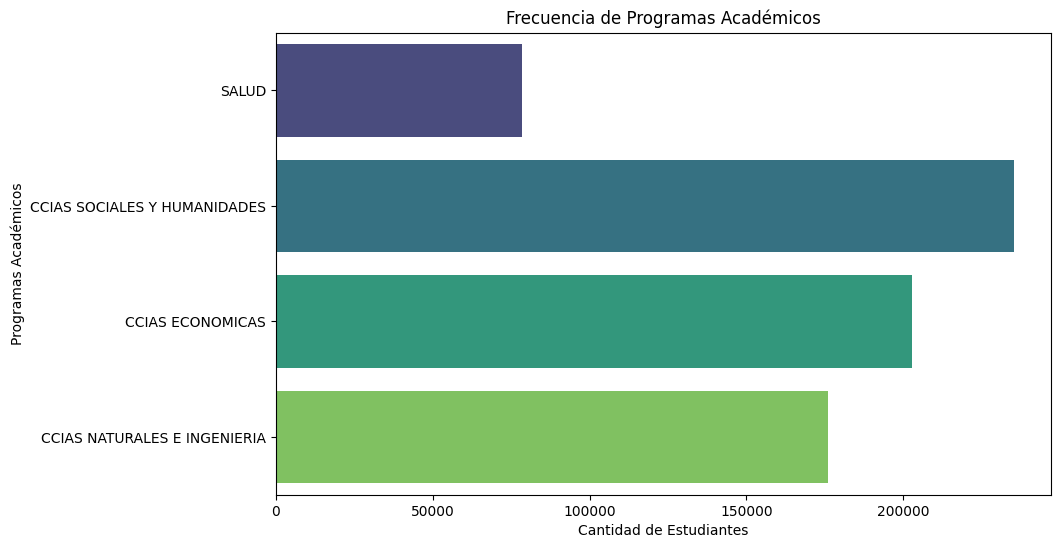

<ipython-input-175-7a02fa491d5f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_program, ax=ax, palette="viridis",
<ipython-input-175-7a02fa491d5f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_program, ax=ax, palette="viridis",
<ipython-input-175-7a02fa491d5f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_program, ax=ax, palette="viridis",
<ipython-input-175-7a02fa491d5f>:24: FutureWarning: 

Passing `palette` without assig

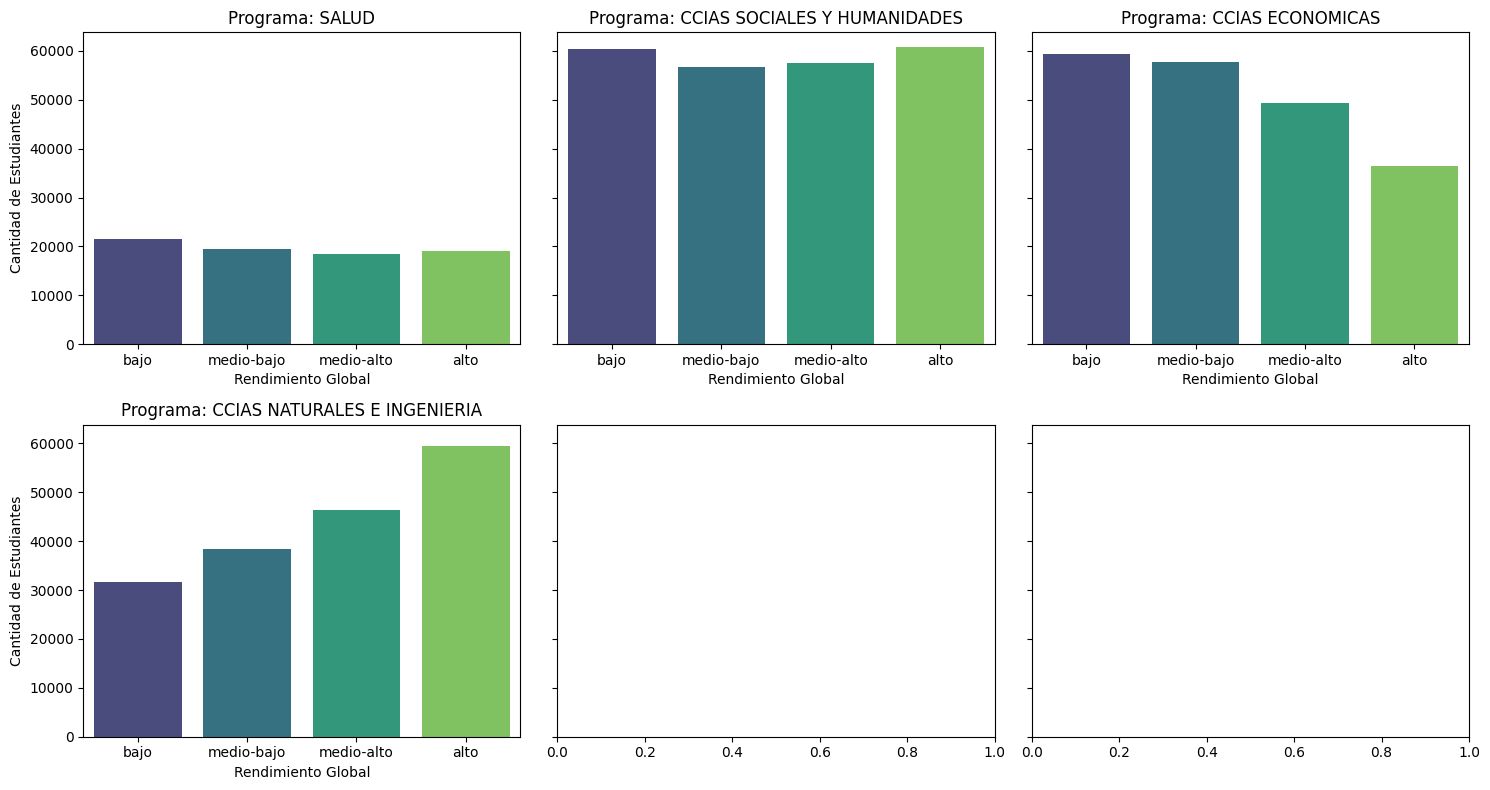

In [175]:
#Histograma general de la columna ESTU_PRGM_ACADEMICO
plt.figure(figsize=(10, 6))
sns.countplot(data=Data, y='ESTU_PRGM_ACADEMICO', palette="viridis")
plt.title('Frecuencia de Programas Académicos')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Programas Académicos')
plt.show()

# Subgráficos de barras (Rendimiento Global vs Programa Académico)
#Lista de valores únicos en ESTU_PRGM_ACADEMICO
unique_programs = Data['ESTU_PRGM_ACADEMICO'].unique()

#Ajustar el número de filas y columnas según la cantidad de programas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)  # Ajustado a 2 filas y 3 columnas
axes = axes.flatten()

#Iterar sobre cada programa académico para crear un gráfico de barras
for i, program in enumerate(unique_programs):
    ax = axes[i]
    #Filtrar los datos para el programa académico correspondiente
    data_program = Data[Data['ESTU_PRGM_ACADEMICO'] == program]

    #Crear gráfico de barras para el programa académico
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_program, ax=ax, palette="viridis",
                  order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Título para cada subplot
    ax.set_title(f'Programa: {program}')
    #Etiquetas
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

# Ajustar el layout
plt.tight_layout()
plt.show()

# **Columna ESTU_VALORMATRICULAUNIVERSIDAD**

- Tenemos 8 Valores posibles que puede tomar la columna, estos valores comprenden un rango y se encuentran definidos de manera cualitativa.
- Para tratar con estos datos, tomaremos inicialmente el promedio numérico del rango de valores y lo asignaremos según corresponda.
  - No pagó matrícula  = 0
  - Menos de 500 mil = 250000
  - Entre 500 mil y menos de 1 millón = 750000
  - Entre 1 millón y menos de 2.5 millones = 1750000
  - Entre 2.5 millones y menos de 4 millones = 3250000
  - Entre 4 millones y menos de 5.5 millones = 4750000
  - Entre 5.5 millones y menos de 7 millones = 6250000
  - Más de 7 millones (Tratado como si estuvieramos hablando del rango entre 7 millones y 8.5 millones) = 7750000

- Para los datos Nulos validaremos cada Promedio de costo de matricula respecto al rendimiento. Si encontramos que el patrón de comportamiento de los valores nulos se acomada a alguno de los rangos de valores, asignaremos dicho valor.

In [176]:
#Imprimir Valores Posibles de la columna ESTU_VALORMATRICULAUNIVERSIDAD
valores_matricula = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].unique()
print(valores_matricula)

['Entre 5.5 millones y menos de 7 millones'
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones' 'Más de 7 millones'
 'Entre 1 millón y menos de 2.5 millones'
 'Entre 500 mil y menos de 1 millón' 'Menos de 500 mil'
 'No pagó matrícula' nan]


In [177]:
#Diccionario con los mapeos de los valores a reemplazar
NewValorMatricula = {
    'No pagó matrícula': 0,
    'Menos de 500 mil': 250000,
    'Entre 500 mil y menos de 1 millón': 750000,
    'Entre 1 millón y menos de 2.5 millones': 1750000,
    'Entre 2.5 millones y menos de 4 millones': 3250000,
    'Entre 4 millones y menos de 5.5 millones': 4750000,
    'Entre 5.5 millones y menos de 7 millones': 6250000,
    'Más de 7 millones': 7750000
}

#Reemplazar los valores en la columna ESTU_VALORMATRICULAUNIVERSIDAD usando el diccionario
Data['ESTU_VALORMATRICULAUNIVERSIDAD'] = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(NewValorMatricula)

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_VALORMATRICULAUNIVERSIDAD'].head(10))

0    6250000.0
1    3250000.0
2    3250000.0
3    4750000.0
4    3250000.0
5    7750000.0
6    3250000.0
7    1750000.0
8    6250000.0
9    3250000.0
Name: ESTU_VALORMATRICULAUNIVERSIDAD, dtype: float64


<ipython-input-177-ecaee8309d3e>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_VALORMATRICULAUNIVERSIDAD'] = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(NewValorMatricula)


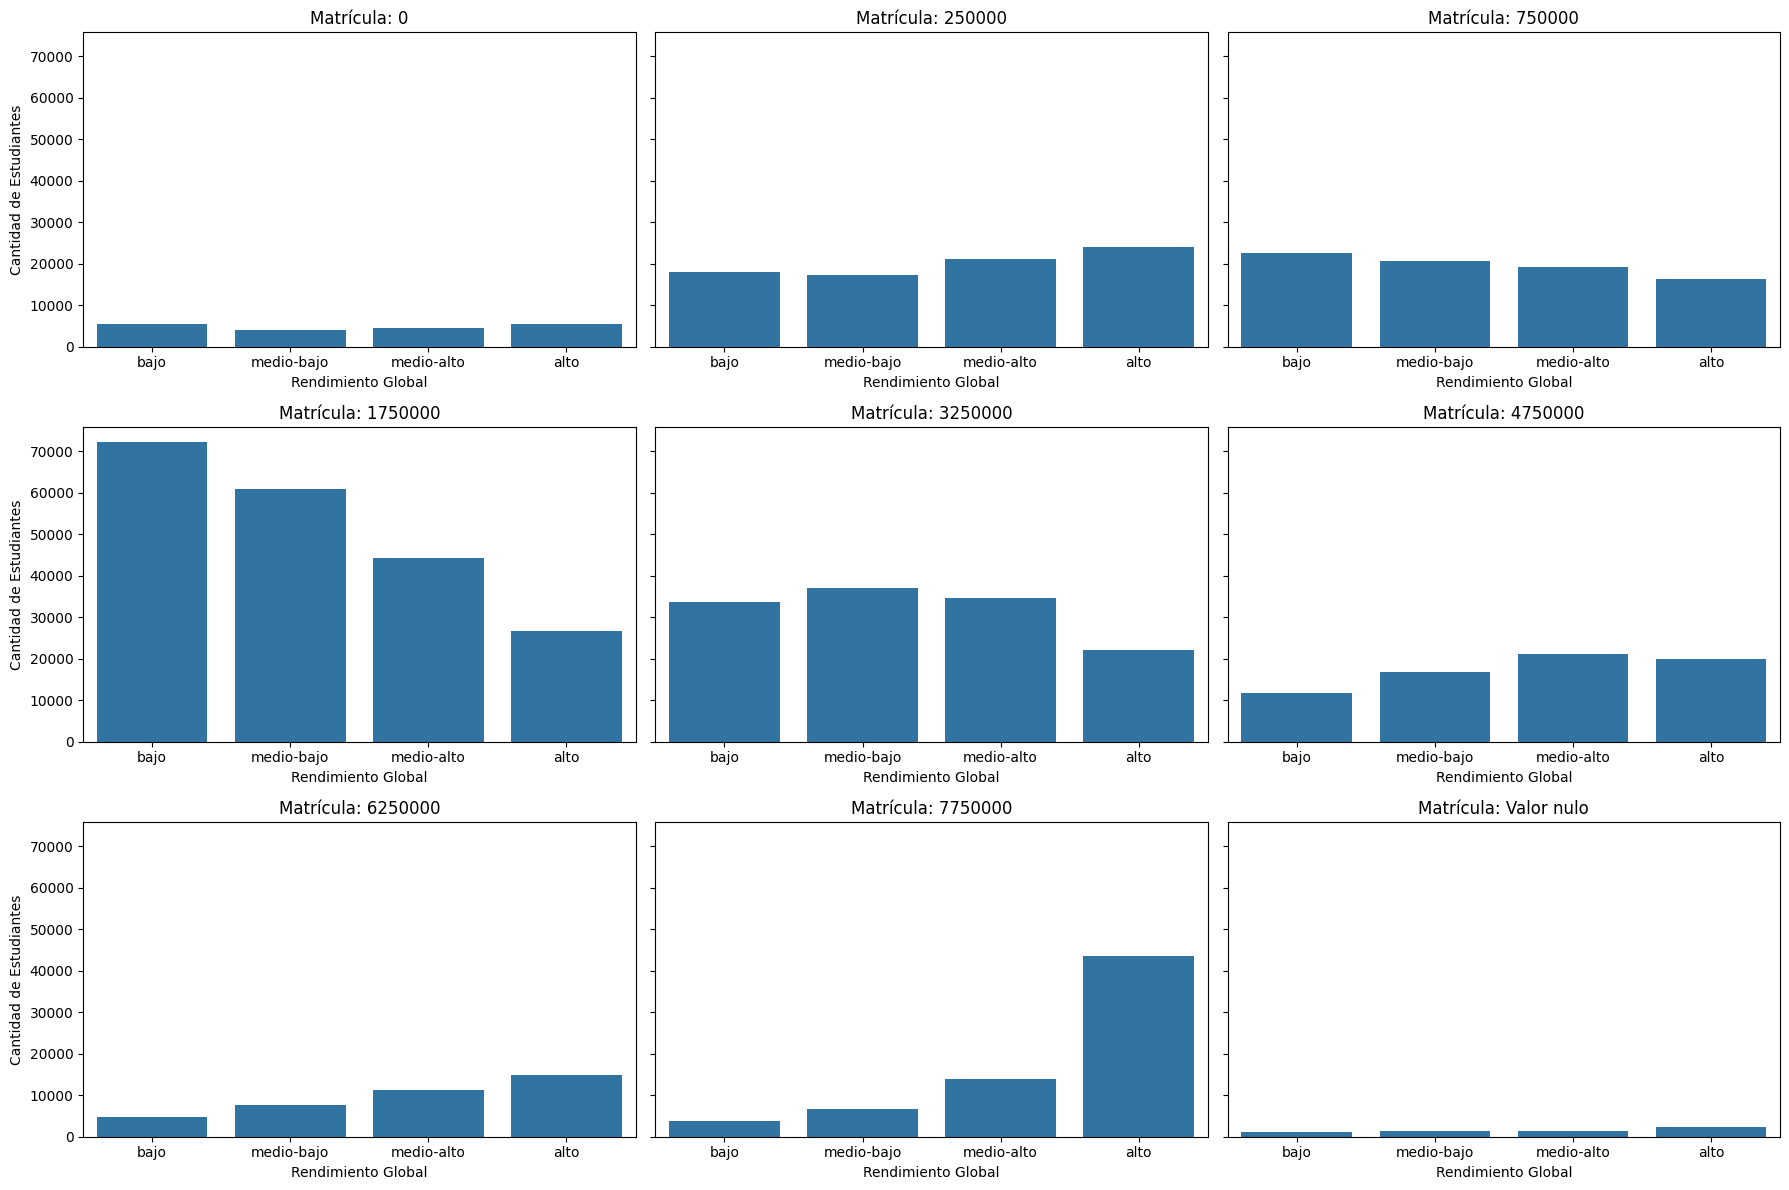

In [178]:
import seaborn as sns

#Valores Null en 'ESTU_VALORMATRICULAUNIVERSIDAD' se reemplazan por 'Valor nulo'
Data['ESTU_VALORMATRICULAUNIVERSIDAD'] = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('Valor nulo')

#Crear una figura con subplots para cada categoría de matrícula (3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey=True)

#Lista de valores de matrícula
valores_matricula = ['0', '250000', '750000', '1750000', '3250000', '4750000', '6250000', '7750000', 'Valor nulo']

#Recorrer cada valor de matrícula para crear un gráfico individual
for i, valor in enumerate(valores_matricula):
    #Fila y columna de los gráficos
    #Ajuste para 3 columnas
    row, col = divmod(i, 3)

    #Filtrar los datos para la categoría de matrícula actual
    #Filtrar por "Valor nulo"
    if valor == 'Valor nulo':
        subset = Data[Data['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Valor nulo']
    else:
        subset = Data[Data['ESTU_VALORMATRICULAUNIVERSIDAD'] == int(valor)]

    #Crear gráfico de barras para el rendimiento global dentro de la categoría de matrícula
    sns.countplot(data=subset, x='RENDIMIENTO_GLOBAL', ax=axes[row, col], order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Configurar títulos y ejes
    axes[row, col].set_title(f'Matrícula: {valor}')
    axes[row, col].set_xlabel('Rendimiento Global')
    axes[row, col].set_ylabel('Cantidad de Estudiantes')

#Ajustar el espaciado entre gráficos
plt.tight_layout()

#Mostrar los gráficos
plt.show()

In [179]:
#Contar cuántos datos tienen 'Valor nulo' en la columna
nulos = Data[Data['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Valor nulo'].shape[0]

#Contar el total de datos en la columna
total = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].shape[0]

#Calcular el porcentaje de 'Valor nulo'
porcentaje_nulos = (nulos / total) * 100

#Imprimir resultados
print(f"Cantidad de 'Valor nulo': {nulos}")
print(f"Porcentaje de 'Valor nulo': {porcentaje_nulos:.2f}%")

Cantidad de 'Valor nulo': 6287
Porcentaje de 'Valor nulo': 0.91%


Valor O VS Valor Nulo

<ipython-input-181-0ad1a75a5adc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Categoria'] = data_filtered['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(0, 'Matrícula 0')


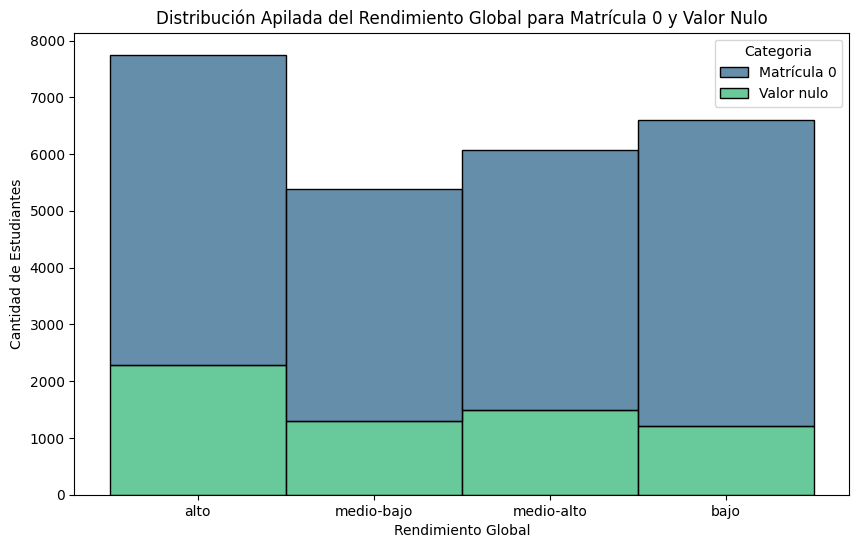

In [181]:
#Filtrar los datos donde el valor es 0 y 'Valor nulo'
data_filtered = Data[Data['ESTU_VALORMATRICULAUNIVERSIDAD'].isin([0, 'Valor nulo'])]

#Crear una nueva columna que combine los valores de matrícula y el rendimiento global
data_filtered['Categoria'] = data_filtered['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(0, 'Matrícula 0')

#Crear gráfico de barras apilado
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtered, x='RENDIMIENTO_GLOBAL', hue='Categoria', multiple='stack', palette="viridis")

#Títulos y etiquetas
plt.title('Distribución Apilada del Rendimiento Global para Matrícula 0 y Valor Nulo')
plt.xlabel('Rendimiento Global')
plt.ylabel('Cantidad de Estudiantes')

#Mostrar el gráfico
plt.show()


Observamos que la influencia de los valores Nulos en la columna es Baja. Por lo que se decide reemplazar dichos Valores por Cero. Además el comportamiento en cuanto a la predicción es similar a los resultados de los estudiante con valor de matricula 0 es similar

In [182]:
#Reemplazar 'Valor nulo' por 0 en la columna ESTU_VALORMATRICULAUNIVERSIDAD
Data['ESTU_VALORMATRICULAUNIVERSIDAD'] = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].replace('Valor nulo', 0)

#Verificar los cambios
print(Data['ESTU_VALORMATRICULAUNIVERSIDAD'].unique())

[6250000. 3250000. 4750000. 7750000. 1750000.  750000.  250000.       0.]


<ipython-input-182-e586b4a7d2f4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_VALORMATRICULAUNIVERSIDAD'] = Data['ESTU_VALORMATRICULAUNIVERSIDAD'].replace('Valor nulo', 0)


In [183]:
print(Data['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts())

ESTU_VALORMATRICULAUNIVERSIDAD
1750000.0    204048
3250000.0    127430
250000.0      80263
750000.0      78704
4750000.0     69736
7750000.0     68014
6250000.0     38490
0.0           25815
Name: count, dtype: int64


# **Columna ESTU_PRGM_DEPARTAMENTO**


*   Se cuentan con 31 valores posibles de los 32 departamentos con los que cuenta el país.
*   Se contempla agrupar los departamentos por regiones. Se cuenta con Archivo Excel




In [184]:
import unicodedata

#Función para normalizar los textos: eliminar tildes y convertir a mayúsculas
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.upper()
        texto = ''.join((c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'))  # Eliminar tildes
    return texto

#Cargar el archivo Excel con las columnas 'Departamento' y 'Región'
departamento_region_df = pd.read_excel('Regiones.xlsx', sheet_name='Sheet1')

#Normalizar las columnas 'Departamento' y 'Región' en el archivo Excel
departamento_region_df['Departamento'] = departamento_region_df['Departamento'].apply(normalizar_texto)
departamento_region_df['Región'] = departamento_region_df['Región'].apply(normalizar_texto)

#Normalizar la columna 'ESTU_PRGM_DEPARTAMENTO' en el dataset (Data)
Data['ESTU_PRGM_DEPARTAMENTO'] = Data['ESTU_PRGM_DEPARTAMENTO'].apply(normalizar_texto)

#Crear un diccionario de reemplazo a partir de las columnas 'Departamento' y 'Región'
reemplazos_departamento_region = dict(zip(departamento_region_df['Departamento'], departamento_region_df['Región']))

#Reemplazar los valores en la columna 'ESTU_PRGM_DEPARTAMENTO' con las regiones correspondientes
Data['ESTU_PRGM_DEPARTAMENTO'] = Data['ESTU_PRGM_DEPARTAMENTO'].replace(reemplazos_departamento_region)

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_PRGM_DEPARTAMENTO'].head())

0    ANDINA
1    CARIBE
2    ANDINA
3    ANDINA
4    ANDINA
Name: ESTU_PRGM_DEPARTAMENTO, dtype: object


In [185]:
#Imprimir Regiones Posibles de la columna ESTU_PRGM_DEPARTAMENTO
Regiones = Data['ESTU_PRGM_DEPARTAMENTO'].unique()
print(Regiones)

['ANDINA' 'CARIBE' 'AMAZONIA' 'PACIFICA' 'ORINOQUIA']


<ipython-input-186-cc12028bbf03>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='ESTU_PRGM_DEPARTAMENTO', palette="viridis")


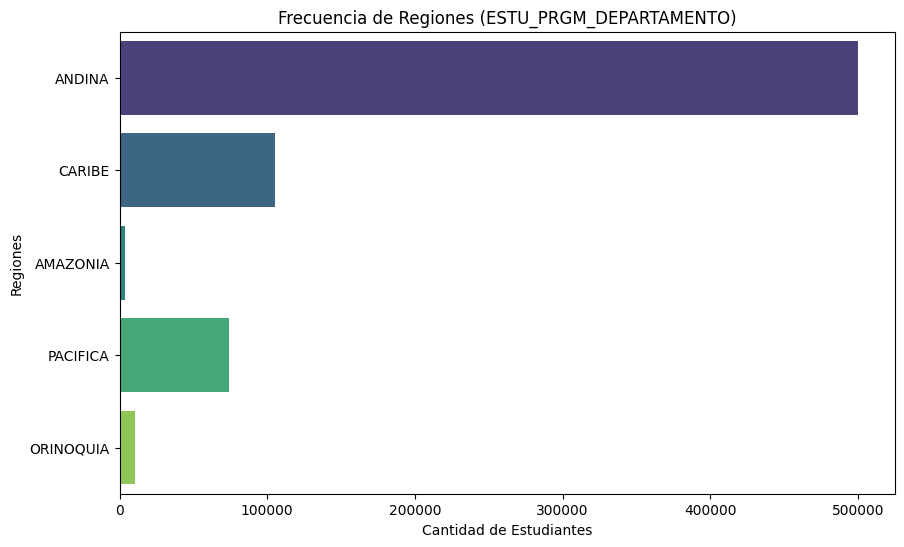

<ipython-input-186-cc12028bbf03>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_region, ax=ax, palette="viridis",
<ipython-input-186-cc12028bbf03>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_region, ax=ax, palette="viridis",
<ipython-input-186-cc12028bbf03>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_region, ax=ax, palette="viridis",
<ipython-input-186-cc12028bbf03>:25: FutureWarning: 

Passing `palette` without assignin

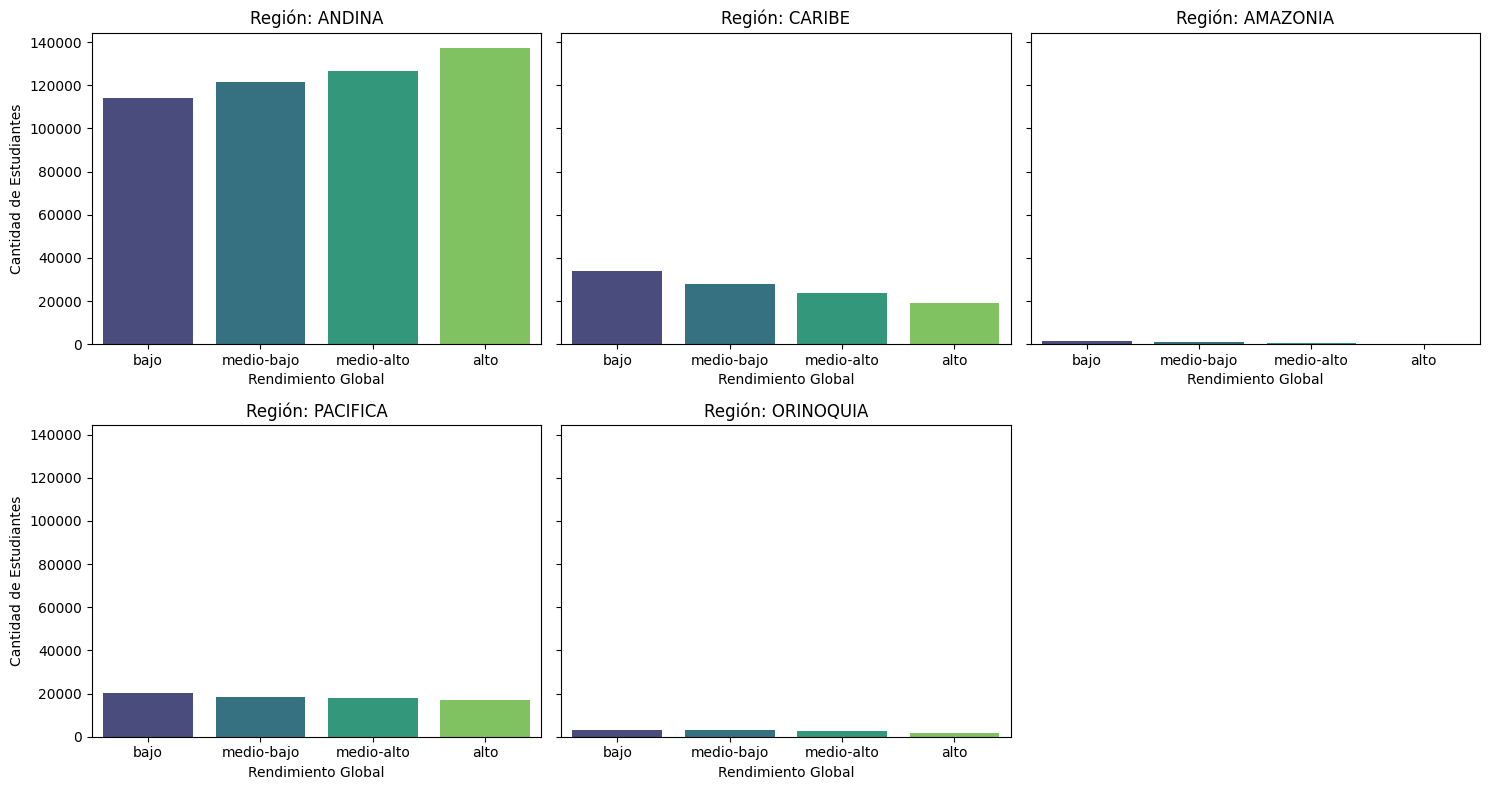

In [186]:
#Histograma general de la columna ESTU_PRGM_DEPARTAMENTO
plt.figure(figsize=(10, 6))
sns.countplot(data=Data, y='ESTU_PRGM_DEPARTAMENTO', palette="viridis")
plt.title('Frecuencia de Regiones (ESTU_PRGM_DEPARTAMENTO)')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Regiones')
plt.show()

#Subgráficos de barras (Rendimiento Global vs Regiones)
#Lista de valores únicos en ESTU_PRGM_DEPARTAMENTO
regiones = Data['ESTU_PRGM_DEPARTAMENTO'].unique()

#Ajustar el número de filas y columnas según la cantidad de valores (5 en este caso)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

#Iterar sobre cada región para crear un gráfico de barras
for i, region in enumerate(regiones):
    if i < len(regiones):
        ax = axes[i]
        #Filtrar los datos para la región correspondiente
        data_region = Data[Data['ESTU_PRGM_DEPARTAMENTO'] == region]

        #Crear gráfico de barras para la región
        sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_region, ax=ax, palette="viridis",
                      order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

        #Título para cada subplot
        ax.set_title(f'Región: {region}')
        ax.set_xlabel('Rendimiento Global')
        ax.set_ylabel('Cantidad de Estudiantes')

#Eliminar gráficos vacíos en caso de que haya más subplots que regiones
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Ajustar el layout
plt.tight_layout()
plt.show()

# **Columna ESTU_HORASSEMANATRABAJA**

- Tenemos 5 Valores posibles que puede tomar la columna, estos valores comprenden un rango y se encuentran definidos de manera cualitativa.
- Para tratar con estos datos, tomaremos inicialmente el promedio numérico del rango de valores y lo asignaremos según corresponda.
  - 0 = 0
  - Menos de 10 horas = 5
  - Entre 11 y 20 horas = 15.5
  - Entre 21 y 30 horas = 25.5
  - Más de 30 horas = 48

- Para los datos Nulos validaremos cada Promedio de horas laborales con respecto al rendimiento. Si encontramos que el patrón de comportamiento de los valores nulos se acomada a alguno de los rangos de valores, asignaremos dicho valor.

In [187]:
#Imprimir los valores únicos de la columna ESTU_HORASSEMANATRABAJA
valores_unicos = Data['ESTU_HORASSEMANATRABAJA'].unique()
print(valores_unicos)

['Menos de 10 horas' '0' 'Más de 30 horas' 'Entre 21 y 30 horas'
 'Entre 11 y 20 horas' nan]


In [188]:
#Crear un diccionario para reemplazar los valores en la columna
reemplazos_horas_trabajo = {
    '0': 0,
    'Menos de 10 horas': 5,
    'Entre 11 y 20 horas': 15.5,
    'Entre 21 y 30 horas': 25.5,
    'Más de 30 horas': 48
}

#Reemplazar los valores en la columna, conservando los valores nulos
Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].replace(reemplazos_horas_trabajo)

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_HORASSEMANATRABAJA'].head())

0     5.0
1     0.0
2    48.0
3     0.0
4    25.5
Name: ESTU_HORASSEMANATRABAJA, dtype: float64


<ipython-input-188-d22be3f331bc>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].replace(reemplazos_horas_trabajo)


<ipython-input-189-7f3c4ebd1c8f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='ESTU_HORASSEMANATRABAJA', palette="viridis",


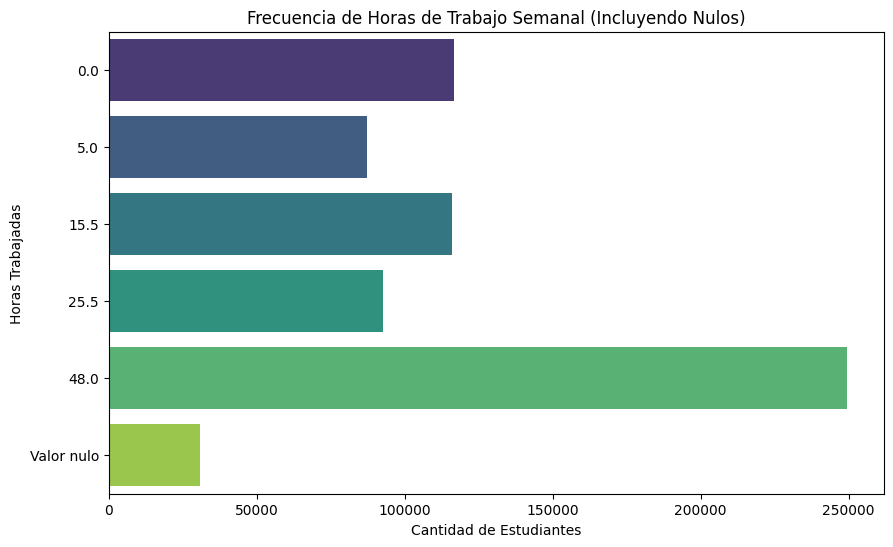

<ipython-input-189-7f3c4ebd1c8f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_horas, ax=ax, palette="viridis",
<ipython-input-189-7f3c4ebd1c8f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_horas, ax=ax, palette="viridis",
<ipython-input-189-7f3c4ebd1c8f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_horas, ax=ax, palette="viridis",
<ipython-input-189-7f3c4ebd1c8f>:34: FutureWarning: 

Passing `palette` without assigning `

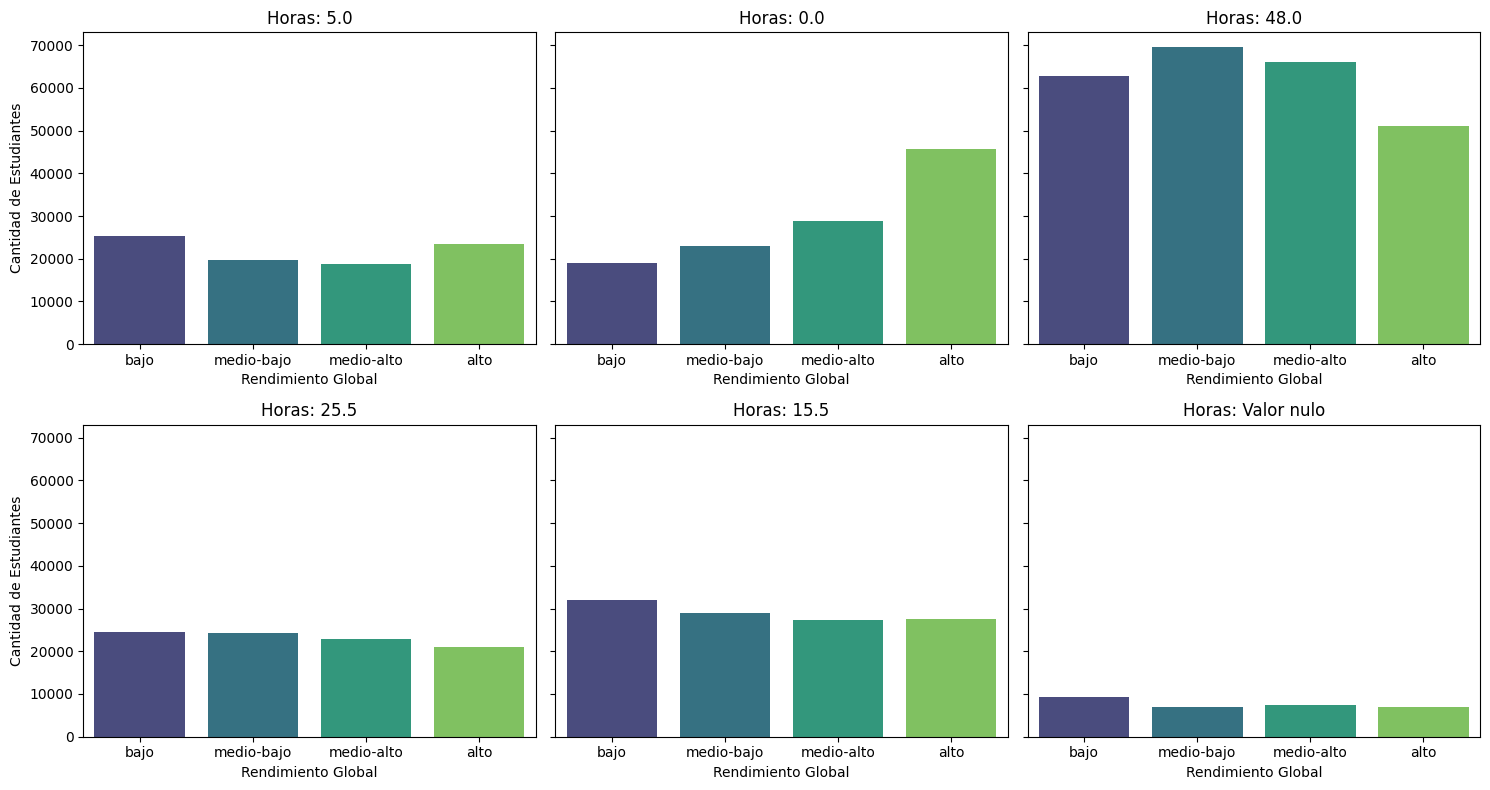

In [189]:
#Reemplazar los valores NaN por 'Valor nulo' temporalmente
Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].fillna('Valor nulo')

#Asegurarse de que solo los valores numéricos se mantengan como float, y 'Valor nulo' como categoría separada
Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].apply(lambda x: 'Valor nulo' if pd.isnull(x) else float(x) if str(x).replace('.', '').isdigit() else x)

#Histograma general de la columna ESTU_HORASSEMANATRABAJA (incluyendo 'Valor nulo')
plt.figure(figsize=(10, 6))

#Graficar los valores incluyendo 'Valor nulo' como categoría separada
sns.countplot(data=Data, y='ESTU_HORASSEMANATRABAJA', palette="viridis",
              order=[0.0, 5.0, 15.5, 25.5, 48.0, 'Valor nulo'])

plt.title('Frecuencia de Horas de Trabajo Semanal (Incluyendo Nulos)')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Horas Trabajadas')
plt.show()

#Subgráficos de barras (Rendimiento Global vs Horas Trabajadas)
#Lista de valores únicos en ESTU_HORASSEMANATRABAJA
horas_trabajo = Data['ESTU_HORASSEMANATRABAJA'].unique()

#Ajustar el número de filas y columnas según la cantidad de valores únicos (incluyendo 'Valor nulo')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

#Iterar sobre cada valor de horas trabajadas (incluyendo 'Valor nulo')
for i, horas in enumerate(horas_trabajo):
    ax = axes[i]
    #Filtrar los datos para las horas trabajadas correspondientes
    data_horas = Data[Data['ESTU_HORASSEMANATRABAJA'] == horas]

    #Crear gráfico de barras para las horas trabajadas
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_horas, ax=ax, palette="viridis",
                  order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Título para cada subplot
    ax.set_title(f'Horas: {horas}')
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

#Eliminar gráficos vacíos en caso de que haya más subplots que valores únicos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Ajustar el layout
plt.tight_layout()
plt.show()

Para los valores Nulos se decide asignar el promedio de los valores que tienen tendencias más uniformes. 5 - 25.5 y 15.5.

Como el promedio arrojo 15.33 - Se decide asignar el valor de 15.5

In [190]:
#Reemplazar 'Valor nulo' por 15.5 en la columna ESTU_HORASSEMANATRABAJA
Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].replace('Valor nulo', 15.5)

# Verificar que 'Valor nulo' fue reemplazado
print(Data['ESTU_HORASSEMANATRABAJA'].value_counts())

ESTU_HORASSEMANATRABAJA
48.0    249352
15.5    146714
0.0     116550
25.5     92693
5.0      87191
Name: count, dtype: int64


<ipython-input-190-0f7d7bdb0f9d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_HORASSEMANATRABAJA'] = Data['ESTU_HORASSEMANATRABAJA'].replace('Valor nulo', 15.5)


# **Columna FAMI_ESTRATOVIVIENDA**

En este caso se tienen 7 posibles valores. Por lo que se decide asignar los valores en Dataset de la siguiente manera:

- Sin Estrato = 0
- Estrato 1 = 1
- Estrato 2 = 2
- Estrato 3 = 3
- Estrato 4 = 4
- Estrato 5 = 5
- Estrato 6 = 6

In [191]:
#Imprimir los valores únicos de la columna FAMI_ESTRATOVIVIENDA
valores_unicos = Data['FAMI_ESTRATOVIVIENDA'].unique()
print(valores_unicos)

['Estrato 3' 'Estrato 4' 'Estrato 5' 'Estrato 2' 'Estrato 1' nan
 'Estrato 6' 'Sin Estrato']


In [192]:
#Crear un diccionario para reemplazar los valores
reemplazos_estrato = {
    'Sin Estrato': 0,
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6
}

#Reemplazar los valores en la columna FAMI_ESTRATOVIVIENDA
Data['FAMI_ESTRATOVIVIENDA'] = Data['FAMI_ESTRATOVIVIENDA'].replace(reemplazos_estrato)

#Verificar los primeros valores después del reemplazo
print(Data['FAMI_ESTRATOVIVIENDA'].head())

0    3.0
1    3.0
2    3.0
3    4.0
4    3.0
Name: FAMI_ESTRATOVIVIENDA, dtype: float64


<ipython-input-192-24e46eae162c>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['FAMI_ESTRATOVIVIENDA'] = Data['FAMI_ESTRATOVIVIENDA'].replace(reemplazos_estrato)


<ipython-input-193-1557d8448451>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='FAMI_ESTRATOVIVIENDA', palette="viridis",


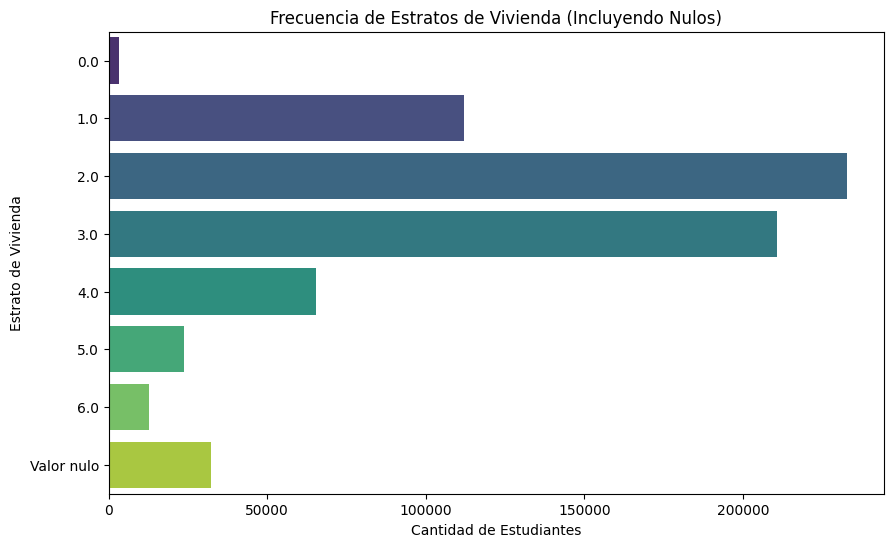

<ipython-input-193-1557d8448451>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_estrato, ax=ax, palette="viridis",
<ipython-input-193-1557d8448451>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_estrato, ax=ax, palette="viridis",
<ipython-input-193-1557d8448451>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_estrato, ax=ax, palette="viridis",
<ipython-input-193-1557d8448451>:31: FutureWarning: 

Passing `palette` without assig

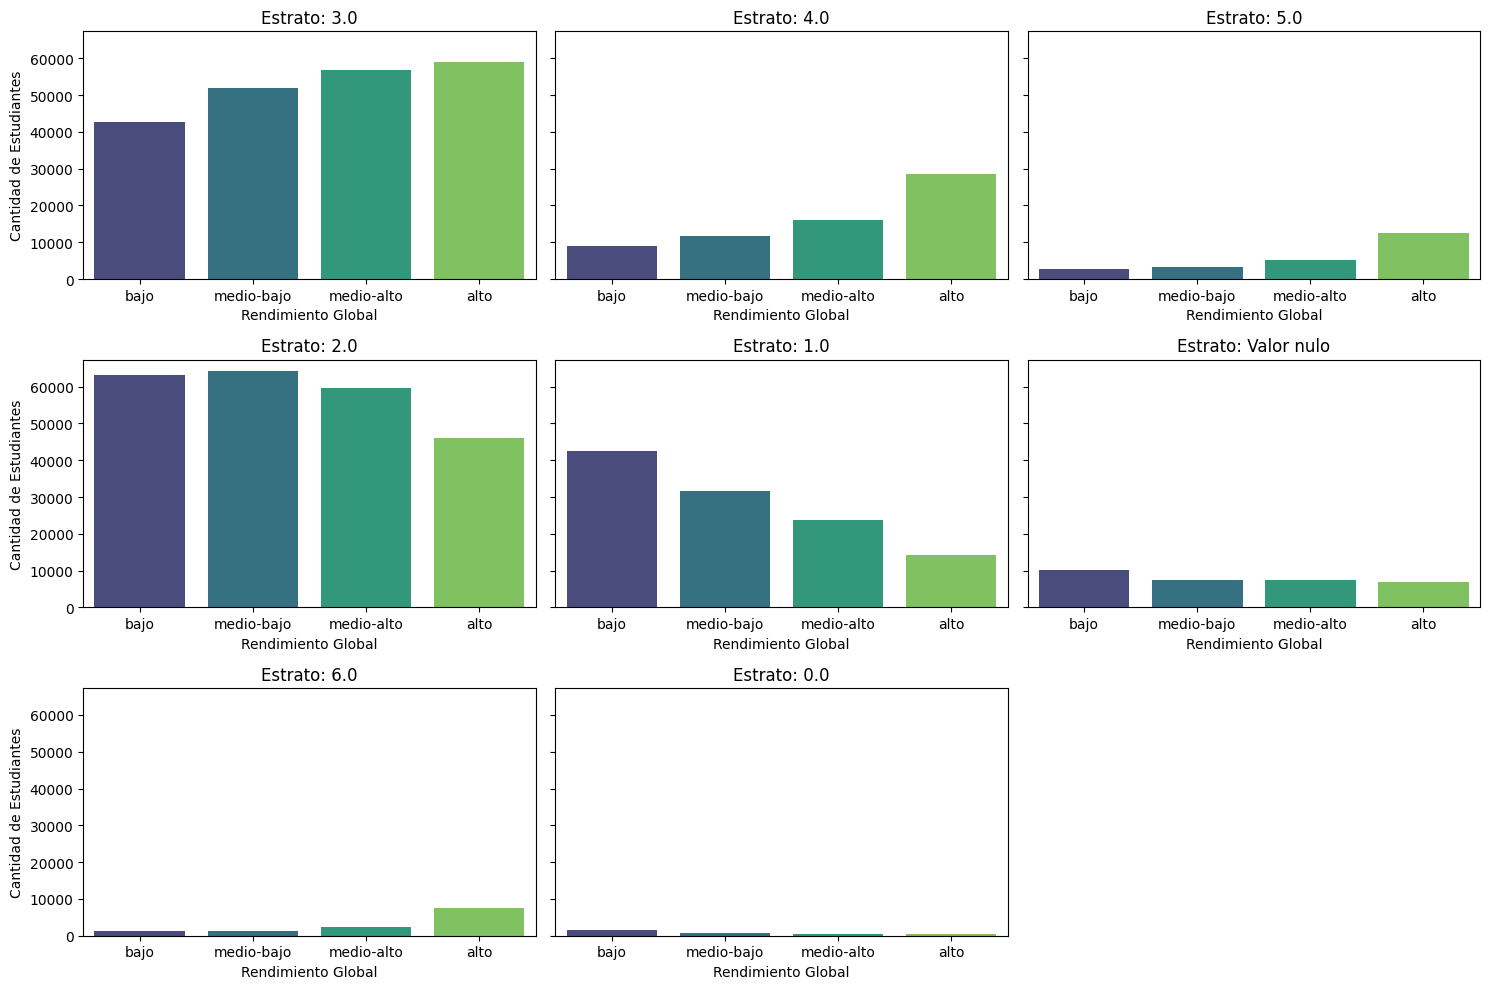

In [193]:
#Reemplazar los valores NaN por 'Valor nulo' temporalmente para los gráficos
Data['FAMI_ESTRATOVIVIENDA'] = Data['FAMI_ESTRATOVIVIENDA'].fillna('Valor nulo')

#Histograma general de la columna FAMI_ESTRATOVIVIENDA
plt.figure(figsize=(10, 6))

#Graficar los valores incluyendo 'Valor nulo' como categoría separada
sns.countplot(data=Data, y='FAMI_ESTRATOVIVIENDA', palette="viridis",
              order=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 'Valor nulo'])

plt.title('Frecuencia de Estratos de Vivienda (Incluyendo Nulos)')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Estrato de Vivienda')
plt.show()

#Subgráficos de barras (Rendimiento Global vs Estrato de Vivienda)
#Lista de valores únicos en FAMI_ESTRATOVIVIENDA
estratos = Data['FAMI_ESTRATOVIVIENDA'].unique()

#Ajustar el número de filas y columnas según la cantidad de valores únicos (incluyendo 'Valor nulo')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

#Iterar sobre cada valor de estrato (incluyendo 'Valor nulo')
for i, estrato in enumerate(estratos):
    ax = axes[i]
    #Filtrar los datos para el estrato correspondiente
    data_estrato = Data[Data['FAMI_ESTRATOVIVIENDA'] == estrato]

    #Crear gráfico de barras para el estrato de vivienda
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_estrato, ax=ax, palette="viridis",
                  order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Título para cada subplot
    ax.set_title(f'Estrato: {estrato}')
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

#Eliminar gráficos vacíos en caso de que haya más subplots que valores únicos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Ajustar el layout
plt.tight_layout()
plt.show()

Por términos prácticos y teniendo en cuenta los datos presentados, se decide asignar 0 a los valores Nulos

<ipython-input-194-db040cca58f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['Grupo'] = 'Estrato 0'
<ipython-input-194-db040cca58f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valor_nulo['Grupo'] = 'Valor nulo'


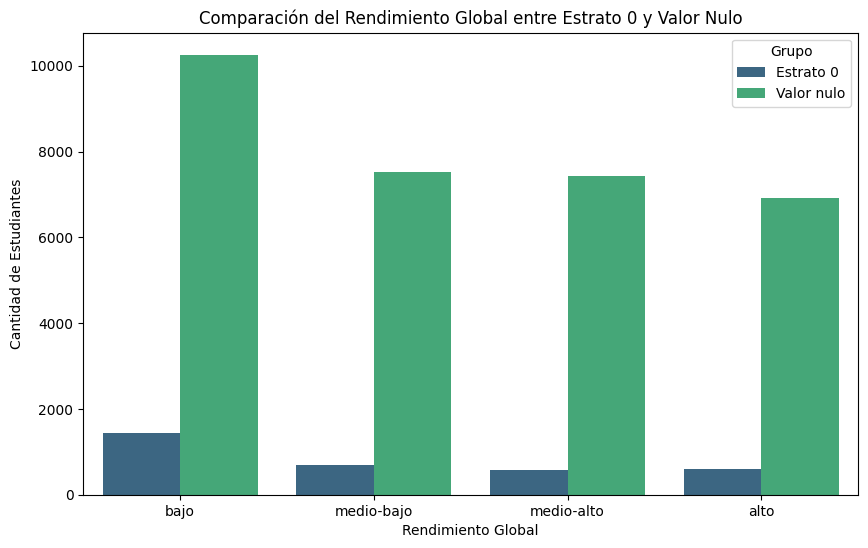

In [194]:
#Filtrar los datos para los valores 0 y 'Valor nulo'
data_0 = Data[Data['FAMI_ESTRATOVIVIENDA'] == 0]
data_valor_nulo = Data[Data['FAMI_ESTRATOVIVIENDA'] == 'Valor nulo']

#Concatenar ambos subconjuntos de datos y agregar una columna para indicar el grupo
data_0['Grupo'] = 'Estrato 0'
data_valor_nulo['Grupo'] = 'Valor nulo'

#Concatenar ambos subconjuntos en un solo DataFrame
data_comparacion = pd.concat([data_0, data_valor_nulo])

#Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.countplot(data=data_comparacion, x='RENDIMIENTO_GLOBAL', hue='Grupo', palette="viridis",
              order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

#Títulos y etiquetas
plt.title('Comparación del Rendimiento Global entre Estrato 0 y Valor Nulo')
plt.xlabel('Rendimiento Global')
plt.ylabel('Cantidad de Estudiantes')
plt.legend(title='Grupo')

#Mostrar el gráfico
plt.show()

In [195]:
#Reemplazar 'Valor nulo' por 0 en la columna FAMI_ESTRATOVIVIENDA
Data['FAMI_ESTRATOVIVIENDA'] = Data['FAMI_ESTRATOVIVIENDA'].replace('Valor nulo', 0)

#Verificar que el reemplazo se haya hecho correctamente
print(Data['FAMI_ESTRATOVIVIENDA'].unique())  # Mostrar los valores únicos después del reemplazo

[3. 4. 5. 2. 1. 0. 6.]


<ipython-input-195-2b1799ea8ec3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['FAMI_ESTRATOVIVIENDA'] = Data['FAMI_ESTRATOVIVIENDA'].replace('Valor nulo', 0)


# **Columna FAMI_TIENEINTERNET**

Se tienen dos posibilidades de valores. Se realizan los siguientes reemplazos:

- Si = 1
- No = 0

In [196]:
#Imprimir los valores únicos de la columna FAMI_TIENEINTERNET
valores_unicos = Data['FAMI_TIENEINTERNET'].unique()
print(valores_unicos)

['Si' 'No' nan]


In [197]:
#Reemplazar 'Si' por 1 y 'No' por 0 en la columna FAMI_TIENEINTERNET
Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].replace({'Si': 1, 'No': 0})

#Verificar los primeros valores después del reemplazo
print(Data['FAMI_TIENEINTERNET'].head())

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: FAMI_TIENEINTERNET, dtype: float64


<ipython-input-197-7fd271c61898>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].replace({'Si': 1, 'No': 0})


<ipython-input-198-fb6f7b66974f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='FAMI_TIENEINTERNET', palette="viridis",


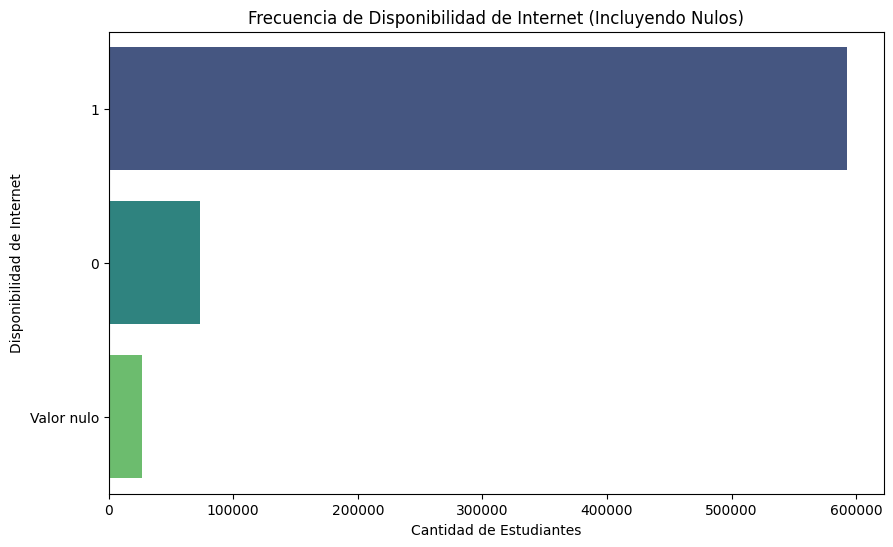

<ipython-input-198-fb6f7b66974f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_internet, ax=ax, palette="viridis",
<ipython-input-198-fb6f7b66974f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_internet, ax=ax, palette="viridis",
<ipython-input-198-fb6f7b66974f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_internet, ax=ax, palette="viridis",


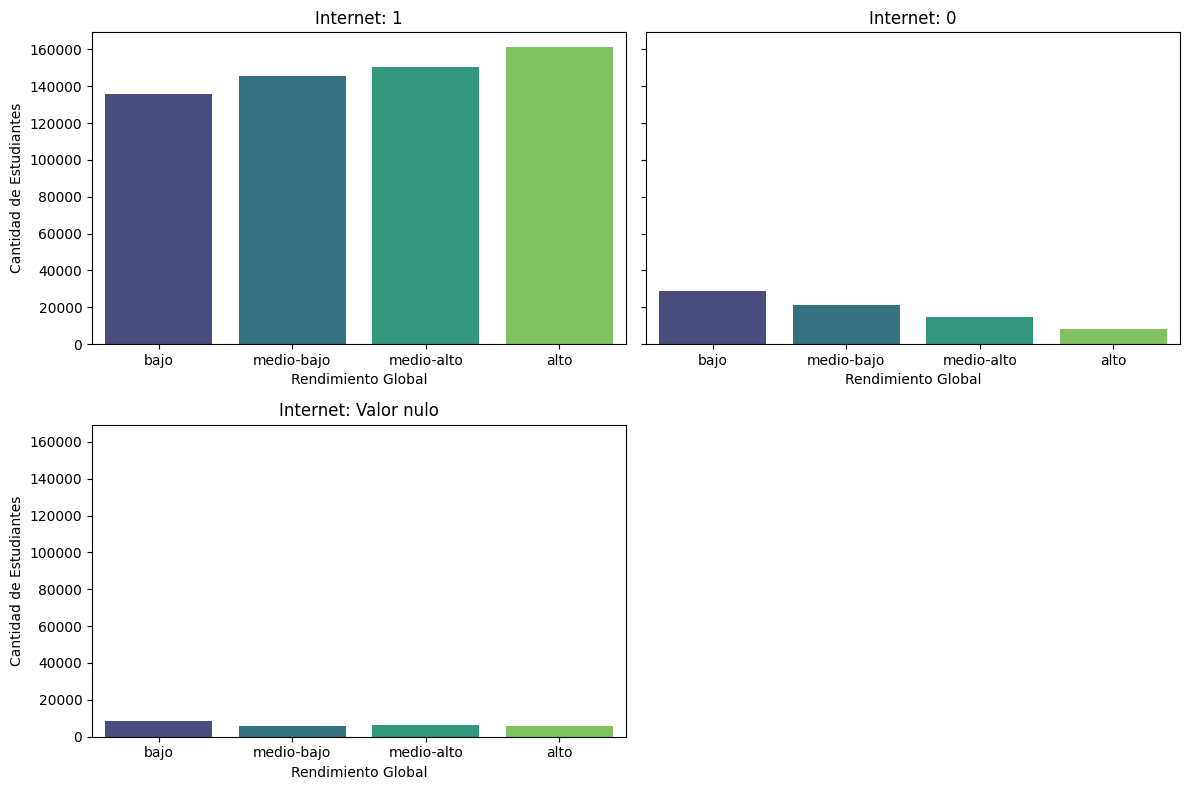

In [198]:
#Reemplazar los valores NaN por 'Valor nulo' temporalmente para los gráficos
Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].fillna('Valor nulo')

#Asegurarse de que los valores sean numéricos, excepto 'Valor nulo'
Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].apply(lambda x: 'Valor nulo' if x == 'Valor nulo' else int(x))

#Histograma general de la columna FAMI_TIENEINTERNET (incluyendo 'Valor nulo')
plt.figure(figsize=(10, 6))

#Graficar los valores incluyendo 'Valor nulo' como categoría separada
sns.countplot(data=Data, y='FAMI_TIENEINTERNET', palette="viridis",
              order=[1, 0, 'Valor nulo'])

plt.title('Frecuencia de Disponibilidad de Internet (Incluyendo Nulos)')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Disponibilidad de Internet')
plt.show()

#Subgráficos de barras (Rendimiento Global vs Disponibilidad de Internet)
#Lista de valores únicos en FAMI_TIENEINTERNET
internet_status = Data['FAMI_TIENEINTERNET'].unique()

#Ajustar el número de filas y columnas según la cantidad de valores únicos (incluyendo 'Valor nulo')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

#Iterar sobre cada valor de disponibilidad de internet (incluyendo 'Valor nulo')
for i, status in enumerate(internet_status):
    ax = axes[i]
    #Filtrar los datos para la disponibilidad de internet correspondiente
    data_internet = Data[Data['FAMI_TIENEINTERNET'] == status]

    #Crear gráfico de barras para la disponibilidad de internet
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_internet, ax=ax, palette="viridis",
                  order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Título para cada subplot
    ax.set_title(f'Internet: {status}')
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

#Eliminar gráficos vacíos en caso de que haya más subplots que valores únicos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Ajustar el layout
plt.tight_layout()
plt.show()

<ipython-input-199-e15469cf154b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_valor_nulo_internet, x='RENDIMIENTO_GLOBAL', palette="viridis",


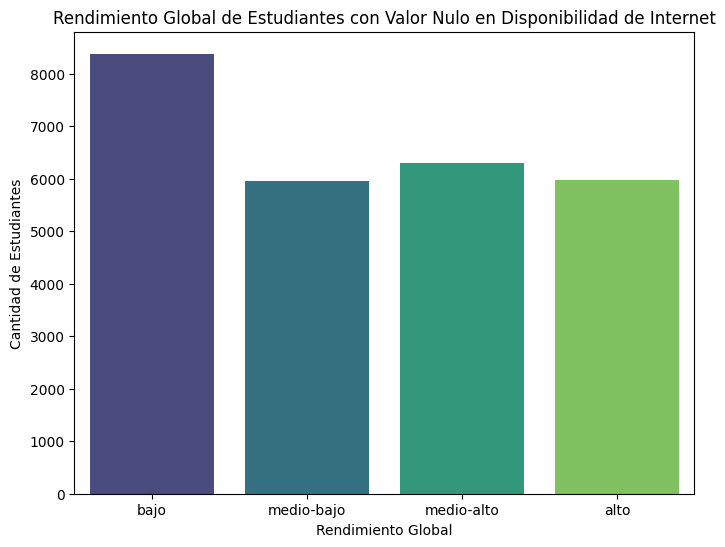

In [199]:
# Filtrar los datos donde el valor es 'Valor nulo' en FAMI_TIENEINTERNET
data_valor_nulo_internet = Data[Data['FAMI_TIENEINTERNET'] == 'Valor nulo']

# Crear el gráfico de barras para el rendimiento global de los estudiantes con 'Valor nulo' en FAMI_TIENEINTERNET
plt.figure(figsize=(8, 6))
sns.countplot(data=data_valor_nulo_internet, x='RENDIMIENTO_GLOBAL', palette="viridis",
              order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

# Título y etiquetas
plt.title('Rendimiento Global de Estudiantes con Valor Nulo en Disponibilidad de Internet')
plt.xlabel('Rendimiento Global')
plt.ylabel('Cantidad de Estudiantes')

# Mostrar el gráfico
plt.show()


Se decide reemplazar los valores Nulos con 0

In [200]:
#Reemplazar 'Valor nulo' por 0 en la columna FAMI_TIENEINTERNET
Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].replace('Valor nulo', 0)

#Verificar los primeros valores después del reemplazo
print(Data['FAMI_TIENEINTERNET'].head())

0    1
1    0
2    1
3    1
4    1
Name: FAMI_TIENEINTERNET, dtype: int64


<ipython-input-200-de6f9800c33d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['FAMI_TIENEINTERNET'] = Data['FAMI_TIENEINTERNET'].replace('Valor nulo', 0)


# **Columnas FAMI_EDUCACIONPADRE y FAMI_EDUCACIONMADRE**

Se deciden retirar estas columnas.

La educación de los padres (tanto del padre como de la madre) puede no tener una relación directa o significativa con el rendimiento académico de los estudiantes en las pruebas estandarizadas, ya que el rendimiento académico de un estudiante depende más de su propio esfuerzo, disciplina y habilidades adquiridas, que de la educación de sus padres



In [201]:
#Eliminar las columnas FAMI_EDUCACIONPADRE y FAMI_EDUCACIONMADRE
Data = Data.drop(columns=['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE'])


# **Columna ESTU_PAGOMATRICULAPROPIO**

Se tienen dos posibilidades de valores. Se realizan los siguientes reemplazos:

- Si = 1
- No = 0

In [202]:
#Reemplazar 'Si' por 1 y 'No' por 0 en la columna ESTU_PAGOMATRICULAPROPIO
Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].replace({'Si': 1, 'No': 0})

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_PAGOMATRICULAPROPIO'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ESTU_PAGOMATRICULAPROPIO, dtype: float64


<ipython-input-202-001ffb1bbc8c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].replace({'Si': 1, 'No': 0})


<ipython-input-203-fbd15d763661>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, y='ESTU_PAGOMATRICULAPROPIO', palette="viridis",


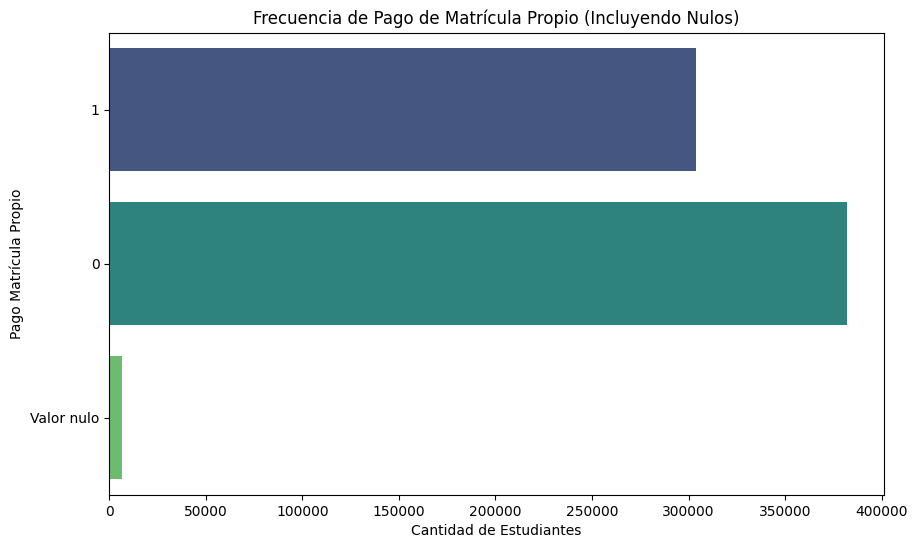

<ipython-input-203-fbd15d763661>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_pago, ax=ax, palette="viridis",
<ipython-input-203-fbd15d763661>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_pago, ax=ax, palette="viridis",
<ipython-input-203-fbd15d763661>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_pago, ax=ax, palette="viridis",


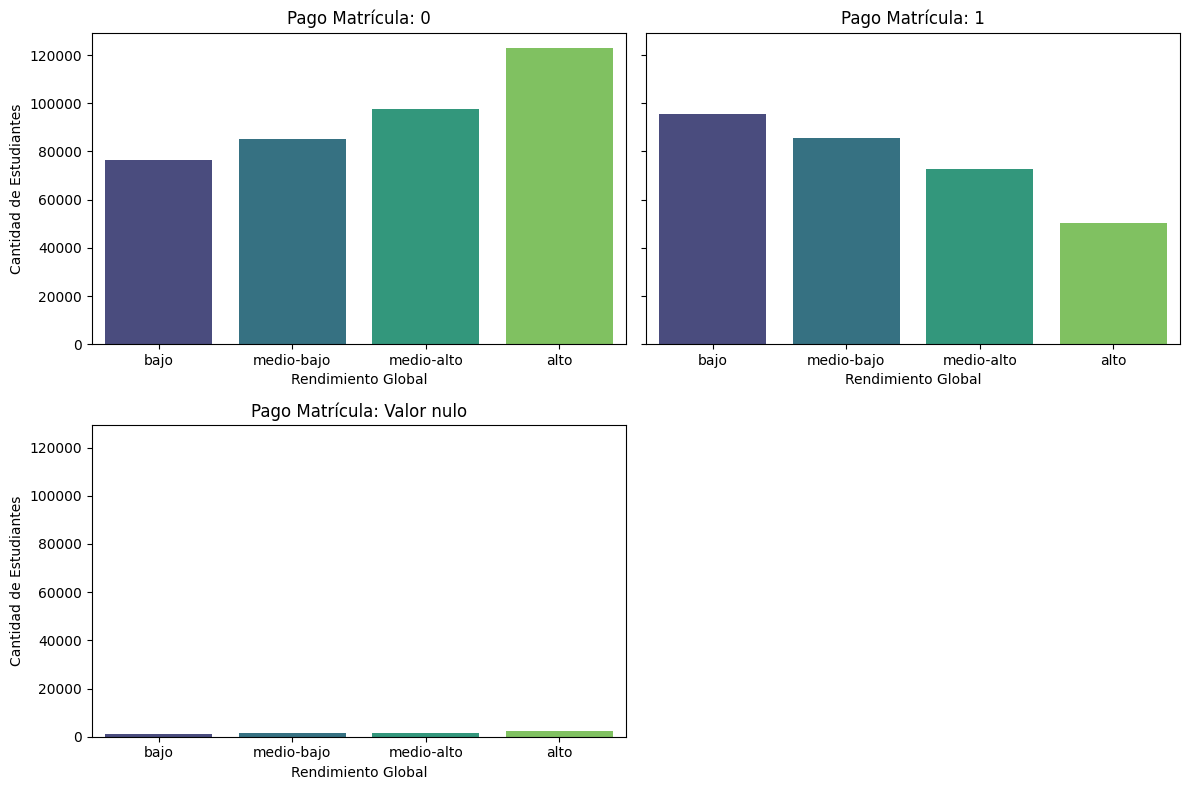

In [203]:
#Reemplazar los valores NaN por 'Valor nulo' temporalmente para los gráficos
Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].fillna('Valor nulo')


#Asegurarse de que los valores 0 y 1 sean numéricos, y mantener 'Valor nulo' como una cadena
Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].apply(lambda x: 'Valor nulo' if x == 'Valor nulo' else int(x))

#Histograma general de la columna ESTU_PAGOMATRICULAPROPIO
plt.figure(figsize=(10, 6))

#Graficar los valores incluyendo 'Valor nulo' como categoría separada
sns.countplot(data=Data, y='ESTU_PAGOMATRICULAPROPIO', palette="viridis",
              order=[1, 0, 'Valor nulo'])

plt.title('Frecuencia de Pago de Matrícula Propio (Incluyendo Nulos)')
plt.xlabel('Cantidad de Estudiantes')
plt.ylabel('Pago Matrícula Propio')
plt.show()

#Subgráficos de barras (Rendimiento Global vs Pago Matrícula Propio)
#Lista de valores únicos en ESTU_PAGOMATRICULAPROPIO
pago_matricula = Data['ESTU_PAGOMATRICULAPROPIO'].unique()

#Ajustar el número de filas y columnas según la cantidad de valores únicos (incluyendo 'Valor nulo')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

#Iterar sobre cada valor de pago de matrícula propio (incluyendo 'Valor nulo')
for i, pago in enumerate(pago_matricula):
    ax = axes[i]
    #Filtrar los datos para el pago de matrícula correspondiente
    data_pago = Data[Data['ESTU_PAGOMATRICULAPROPIO'] == pago]

    #Crear gráfico de barras para el pago de matrícula propio
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=data_pago, ax=ax, palette="viridis",
                  order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

    #Título para cada subplot
    ax.set_title(f'Pago Matrícula: {pago}')
    ax.set_xlabel('Rendimiento Global')
    ax.set_ylabel('Cantidad de Estudiantes')

#Eliminar gráficos vacíos en caso de que haya más subplots que valores únicos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Ajustar el layout
plt.tight_layout()
plt.show()

<ipython-input-204-bc1b7425ab16>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_valor_nulo, x='RENDIMIENTO_GLOBAL', palette="viridis",


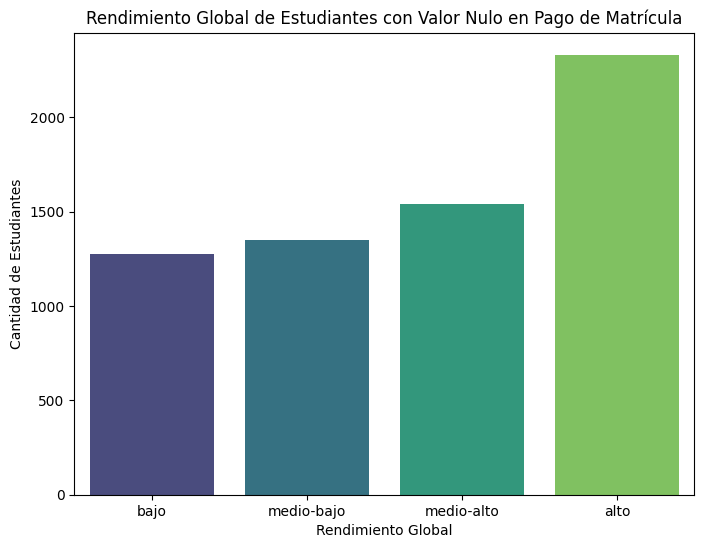

In [204]:
#Filtrar los datos donde el valor es 'Valor nulo' en ESTU_PAGOMATRICULAPROPIO
data_valor_nulo = Data[Data['ESTU_PAGOMATRICULAPROPIO'] == 'Valor nulo']

#Crear el gráfico de barras para el rendimiento global de los estudiantes con 'Valor nulo'
plt.figure(figsize=(8, 6))
sns.countplot(data=data_valor_nulo, x='RENDIMIENTO_GLOBAL', palette="viridis",
              order=['bajo', 'medio-bajo', 'medio-alto', 'alto'])

#Título y etiquetas
plt.title('Rendimiento Global de Estudiantes con Valor Nulo en Pago de Matrícula')
plt.xlabel('Rendimiento Global')
plt.ylabel('Cantidad de Estudiantes')

#Mostrar el gráfico
plt.show()

In [205]:
#Reemplazar 'Valor nulo' por 0 en la columna ESTU_PAGOMATRICULAPROPIO
Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].replace('Valor nulo', 0)

#Verificar los primeros valores después del reemplazo
print(Data['ESTU_PAGOMATRICULAPROPIO'].head())

0    0
1    0
2    0
3    0
4    0
Name: ESTU_PAGOMATRICULAPROPIO, dtype: int64


<ipython-input-205-15c88918108b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['ESTU_PAGOMATRICULAPROPIO'] = Data['ESTU_PAGOMATRICULAPROPIO'].replace('Valor nulo', 0)


# **Columna RENDIMIENTO_GLOBAL**

Se asigna un valor numérico entre 0 a 100% para cada uno de los posibles valores de rendimiento

De esta forma:

- bajo = 25%
- medio-bajo = 50%
- medio-alto = 75%
- alto = 100%

- bajo = 25
- medio-bajo = 50
- medio-alto = 75
- alto = 100

In [206]:
#Crear un diccionario de reemplazo para los valores de RENDIMIENTO_GLOBAL
reemplazos_rendimiento = {
    'bajo': 25,
    'medio-bajo': 50,
    'medio-alto': 75,
    'alto': 100
}

#Reemplazar los valores en la columna RENDIMIENTO_GLOBAL
Data['RENDIMIENTO_GLOBAL'] = Data['RENDIMIENTO_GLOBAL'].replace(reemplazos_rendimiento)

#Verificar los primeros valores después del reemplazo
print(Data['RENDIMIENTO_GLOBAL'].head())

0     75
1     25
2     25
3    100
4     50
Name: RENDIMIENTO_GLOBAL, dtype: int64


<ipython-input-206-a7db21f2b7b3>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['RENDIMIENTO_GLOBAL'] = Data['RENDIMIENTO_GLOBAL'].replace(reemplazos_rendimiento)


# RESUMEN

In [207]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  float64
 4   ESTU_HORASSEMANATRABAJA         692500 non-null  float64
 5   FAMI_ESTRATOVIVIENDA            692500 non-null  float64
 6   FAMI_TIENEINTERNET              692500 non-null  int64  
 7   ESTU_PAGOMATRICULAPROPIO        692500 non-null  int64  
 8   RENDIMIENTO_GLOBAL              692500 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 47.6+ MB


In [208]:
InfoColumns(Data)


Análisis de la columna: PERIODO
Valores únicos: 4
Valores más comunes:
PERIODO
2019    182510
2021    172590
2020    172328
2018    165072
Name: count, dtype: int64
Valores nulos en PERIODO: 0
------------------------------------------------------------------

Análisis de la columna: ESTU_PRGM_ACADEMICO
Valores únicos: 4
Valores más comunes:
ESTU_PRGM_ACADEMICO
CCIAS SOCIALES Y HUMANIDADES    235232
CCIAS ECONOMICAS                202876
CCIAS NATURALES E INGENIERIA    175945
SALUD                            78447
Name: count, dtype: int64
Valores nulos en ESTU_PRGM_ACADEMICO: 0
------------------------------------------------------------------

Análisis de la columna: ESTU_PRGM_DEPARTAMENTO
Valores únicos: 5
Valores más comunes:
ESTU_PRGM_DEPARTAMENTO
ANDINA       499712
CARIBE       105090
PACIFICA      73802
ORINOQUIA     10351
AMAZONIA       3545
Name: count, dtype: int64
Valores nulos en ESTU_PRGM_DEPARTAMENTO: 0
------------------------------------------------------------------


In [211]:
Data.head(10)

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,2021,SALUD,ANDINA,6250000.0,5.0,3.0,1,0,75
1,2021,CCIAS SOCIALES Y HUMANIDADES,CARIBE,3250000.0,0.0,3.0,0,0,25
2,2020,CCIAS ECONOMICAS,ANDINA,3250000.0,48.0,3.0,1,0,25
3,2019,CCIAS ECONOMICAS,ANDINA,4750000.0,0.0,4.0,1,0,100
4,2021,CCIAS SOCIALES Y HUMANIDADES,ANDINA,3250000.0,25.5,3.0,1,0,50
5,2020,SALUD,ANDINA,7750000.0,5.0,5.0,1,0,75
6,2018,CCIAS NATURALES E INGENIERIA,ANDINA,3250000.0,25.5,2.0,1,1,100
7,2018,SALUD,ANDINA,1750000.0,15.5,2.0,1,1,50
8,2021,CCIAS NATURALES E INGENIERIA,CARIBE,6250000.0,5.0,1.0,1,1,50
9,2018,CCIAS ECONOMICAS,ANDINA,3250000.0,48.0,5.0,1,1,100
